<a href="https://colab.research.google.com/github/ahmedhesham47/Bayesian-Network-for-Predicting-ICB-Response/blob/main/Bayes_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ulimit -m unlimited

In [ ]:
!pip install pgmpy

# **Importing Packages**

In [26]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, PC, ExhaustiveSearch, BDsScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import K2Score
from pgmpy.inference import VariableElimination
import random
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import f1_score
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
import numpy as np
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score

# **Loading files**

In [4]:
mrna_cont = pd.read_csv('mrna_cont.tsv', sep='\t')
best_e_genes = pd.read_csv('Best Expression Genes.tsv', sep='\t')
labels_df = pd.read_csv('labels_df.tsv',sep='\t')

# **Data pre-processing**

In [60]:
samples = mrna_cont['Sample Identifier']
mrna_cont.set_index(samples, inplace=True)
best_e_genes_list = best_e_genes['Gene_Name']

reduced_df = mrna_cont[best_e_genes_list]
reduced_df = reduced_df.reset_index()

reduced_df_with_labels = pd.merge(reduced_df, labels_df, on='Sample Identifier')

In [61]:
edges_to_exclude = []
for col in reduced_df_with_labels.iloc[:, 1:].columns:
  edges_to_exclude.append(('ICB Response', col))

# **Discretizing the dataframe**

## **Using mean and standard deviation**

In [62]:
# Calculate mean and standard deviation for each gene (column)
means = reduced_df_with_labels.iloc[:, 1:-1].mean()
std_devs = reduced_df_with_labels.iloc[:, 1:-1].std()

# Function to categorize values
def categorize_value(x, gene, std_unit=1):
    if x < means[gene] - (std_unit*std_devs[gene]):
        return -1
    elif x > means[gene] + (std_unit*std_devs[gene]):
        return 1
    else:
        return 0

# Apply the function to each cell in the DataFrame
std_categorized_df = reduced_df_with_labels.iloc[:, 1:-1].apply(lambda x: x.apply(lambda y: categorize_value(y, x.name)))
std_categorized_df.set_index(samples, inplace=True)
std_categorized_df_with_labels = pd.merge(std_categorized_df, labels_df, on='Sample Identifier')

## **Using Min-Max scaling followed by grouping into n categories**

In [9]:
# Min-Max scaling
df = reduced_df_with_labels.iloc[:, 1:-1]
scaled_df = (df - df.min()) / (df.max() - df.min())

# Function to classify values into groups
def classify_into_groups(value):
    if value == 1:
        return 10
    else:
        return int(value // 0.1) + 1

# Apply the classification to the entire DataFrame
min_max_categorized_df = scaled_df.applymap(classify_into_groups)
min_max_categorized_df = min_max_categorized_df.apply(lambda x: x.astype('category'))
min_max_categorized_df.set_index(samples, inplace=True)
min_max_categorized_df_with_labels = pd.merge(min_max_categorized_df, labels_df, on='Sample Identifier')

# **Bayesian Network**

In [245]:
# Create an instance of BicScore with the DataFrame
bic_score = BicScore(std_categorized_df_with_labels.iloc[:,1:])
K2C_score = K2Score(std_categorized_df_with_labels.iloc[:,1:])
BDs_score = BDsScore(std_categorized_df_with_labels.iloc[:,1:])

# Initialize HillClimbSearch with the DataFrame
hc = HillClimbSearch(std_categorized_df_with_labels.iloc[:,1:])

# Estimate the best model using scoring methods
best_model = hc.estimate(scoring_method=bic_score, max_iter=1000, black_list=edges_to_exclude)
best_model2 = hc.estimate(scoring_method=K2C_score, max_iter=20, black_list=edges_to_exclude)
best_model3 = hc.estimate(scoring_method=BDs_score, max_iter=1000, black_list=edges_to_exclude)

# Learning CPDs (Conditional Probability Distributions)
model = BayesianNetwork(best_model.edges())
model2 = BayesianNetwork(best_model2.edges())
model3 = BayesianNetwork(best_model3.edges())

# estimator1 = BayesianEstimator(model, std_categorized_df_with_labels.iloc[:,1:])
# estimator2 = BayesianEstimator(model2, std_categorized_df_with_labels.iloc[:,1:])
# estimator3 = BayesianEstimator(model3, std_categorized_df_with_labels.iloc[:,1:])

model.fit(std_categorized_df_with_labels.iloc[:90,1:], estimator=BayesianEstimator)
model2.fit(std_categorized_df_with_labels.iloc[:,1:], estimator=MaximumLikelihoodEstimator)
model3.fit(std_categorized_df_with_labels.iloc[:90,1:], estimator=BayesianEstimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# model1_cpts = estimator1.get_parameters(prior_type='BDeu')
# model2_cpts = estimator2.get_parameters(prior_type='BDeu')
# model3_cpts = estimator3.get_parameters(prior_type='BDeu')

# for cpt_model1 in model1_cpts:
#   model.add_cpds(cpt_model1)

# for cpt_model2 in model2_cpts:
#   model2.add_cpds(cpt_model2)

# for cpt_model3 in model3_cpts:
#   model3.add_cpds(cpt_model3)

In [246]:
# Create an inference object
inference = VariableElimination(model2)

# Query the model (example: finding the probability of ICB response being 1)
query_result = inference.map_query(variables=['ICB Response'], evidence={'NOP2':1})
print(query_result)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'ICB Response': 0.0}


In [ ]:
for cpd in model3.cpds:
    print(cpd)

# **Testing the model**

In [239]:
model_nodes = list(model.nodes)
model3_nodes = list(model3.nodes)
model2_nodes = list(model2.nodes)

model_data = std_categorized_df_with_labels.iloc[:,1:][model_nodes]
model3_data = std_categorized_df_with_labels.iloc[:,1:][model3_nodes]
model2_data = std_categorized_df_with_labels.iloc[:,1:][model2_nodes]

In [178]:
correlation_score(model, model_data, test="chi_square", significance_level=0.05)
log_likelihood_score(model, model_data)
structure_score(model, model_data, scoring_method="bic")

-3370.1329388061686

In [240]:
samples = std_categorized_df_with_labels.iloc[90:,:][['Sample Identifier', 'ICB Response']]
sample_ids = list(samples['Sample Identifier'])

In [247]:
list_of_dicts = std_categorized_df_with_labels.iloc[90:,1:-1].to_dict(orient='records')
predictions = {}
for sample_dict, s in zip(list_of_dicts, sample_ids):
  filtered_dict = {key: sample_dict[key] for key in model2_nodes if key in sample_dict}
  query_result = inference.map_query(variables=['ICB Response'], evidence=filtered_dict)
  predictions[s] = query_result['ICB Response']

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [248]:
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['ICB Response'])
predictions_df.reset_index(inplace=True)
predictions_df.columns = ['Sample Identifier', 'ICB Response']

samples.reset_index(inplace=True)
samples.drop('index', axis=1, inplace=True)

In [249]:
((predictions_df == samples).sum() / len(samples)) * 100

Sample Identifier    100.000000
ICB Response          82.758621
dtype: float64

# **Network Visualization**

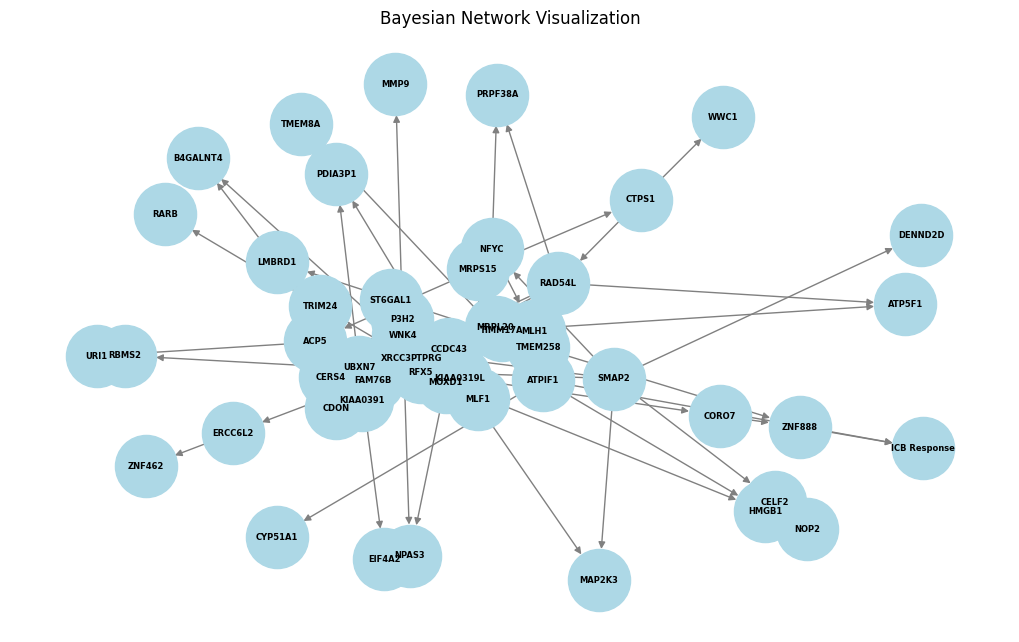

In [84]:
# Create a NetworkX graph from the Bayesian network
G = nx.DiGraph()
G.add_edges_from(best_model3.edges())

# Draw the graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
pos = nx.spring_layout(G)  # Layout for the nodes

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=6, font_weight="bold", edge_color="gray")

# Display the graph
plt.title("Bayesian Network Visualization")
plt.savefig('Bayes_network.png')
plt.show()

In [ ]:
edges_list = [edge for edge in best_model.edges()]
edges_df = pd.DataFrame(edges_list, columns=['Gene 1', 'Gene 2'])
edges_df.to_csv('gene_interactions.tsv', sep='\t', index=False)

# **Quantifying the strength of edges**

In [ ]:
# Initialize a list to store edge data
edge_data = []

# Iterate over each edge
for parent, child in best_model.edges:
    # Get the CPT for the child node
    cpt = model.get_cpds(node=child)

    # Calculate a measure of influence, e.g., range of probabilities
    influence_measure = cpt.values.ptp()  # Example: peak-to-peak (max-min) of the probabilities

    # Append to the edge data
    edge_data.append((parent, child, influence_measure))

# Convert to DataFrame
edges_df = pd.DataFrame(edge_data, columns=['Gene 1', 'Gene 2', 'Association Strength'])

edges_df.to_csv('gene_interactions_strength_quantified.tsv', sep='\t', index=False)

# **Learning**